# Classification
This notebook is a third part of [eargasm-spotify](https://github.com/adamsiemaszkiewicz/eargasm-music) repository. The goal of this part is to build a machine learning model to predict which playlist the track belongs to. The attempt is stricktly experimental because the assignment is most of the time stricktly subjective, it is susceptible to personal biases and tiny musial nuances. 

There are 29 playlists and XXXX unique songs in the dataset. Some of the songs are assigned to more than one playlist which makes things even harder. Nevertheless, let's give it a try.

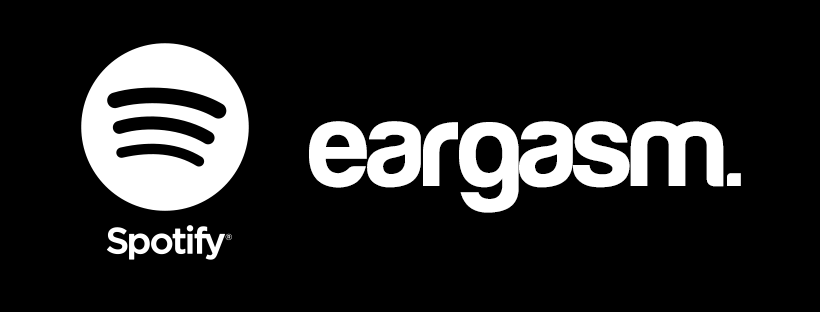

# Set up environment

## Google Drive mount

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/Colab Notebooks/eargasm-music/

/content/gdrive/My Drive/Colab Notebooks/eargasm-music


In [3]:
!ls

eargasm_Classification.ipynb   files	   Untitled0.ipynb
eargasm_DataExploration.ipynb  README.md
eargasm_DataRetrieval.ipynb    test.ipynb


## Import libraries and functions
Let's import all the libraries and function we're gonna use throughout the notebook.

### Notebook
- `tqdm.notebook` `tqdm` - Progress bars
- `timeit` - Measure execution time of small code snippets

In [4]:
from tqdm.notebook import tqdm
import timeit

### Data science
- `pandas` - data manipulation & analysis
- `pd.options.mode.chained_assignment` - switch off warning for chained_assignment
- `numpy` - linear algebra

In [5]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

### Visualization
- `matplotlib.pyplot` - basic visualizations
- `plotly` - advanced visualizations
- `plotly.express` - fast vizualizations
- `plotly.graph_objects` - more control over plotly figures

In [6]:
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go

## Machine learning

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


# estimators
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

# from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
# from sklearn.compose import make_column_transformer
# from sklearn.pipeline import make_pipeline



# Feature engineering

# Load data
Let's load the data fetched from the [Eargasm Music](https://open.spotify.com/user/eargasmusic?si=cz4VzEi1RgaUup_g8-UnEg) Spotify channel using `eargasm_retrieve-data.ipynb`. The data set consists of the tracks with their features as well as a playlist name label.

In [8]:
final_df = pd.read_csv('files/final_df.csv', index_col=0)
final_df.head()

,track_id,track_artist,track_artistid,track_name,track_duration,track_popularity,track_releasedate,track_preview,track_image,track_url,track_playlist,track_genre,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,key,key_confidence,mode,mode_confidence,number_of_sections,tempo,tempo_confidence,time_signature,time_signature_confidence
0,1ua6hBq18qZLyprXjMcpyf,Virgil Howe,6d3Hil7Y1xq0oEhtaDxEUg,Someday,251266,42,2009-10-19,https://p.scdn.co/mp3-preview/a2bdcba6acda937f...,https://i.scdn.co/image/ab67616d0000b27356dc5e...,https://open.spotify.com/track/1ua6hBq18qZLypr...,eargasm | breathe easy,NaN,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.351,9.0,0.292,0.0,0.398,12.0,86.502,0.160,4.0,1.000
1,42VpxSdGQgnV1UJkWeGYkA,Cass McCombs,2iUVQjheBnvOt8vaBrxXJz,Switch,254233,51,2016-08-26,https://p.scdn.co/mp3-preview/d0feea85b84ce9f5...,https://i.scdn.co/image/ab67616d0000b27396782c...,https://open.spotify.com/track/42VpxSdGQgnV1UJ...,eargasm | breathe easy,alternative country,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.713,7.0,0.743,0.0,0.453,12.0,98.003,0.583,4.0,1.000
2,1g8A166soQjwl1ihqBWKGW,The Slow Revolt,7cfCmW2AFiMNdpJdY0vJsr,Lean,207699,0,2016-09-09,NaN,https://i.scdn.co/image/ab67616d0000b273ce48d6...,https://open.spotify.com/track/1g8A166soQjwl1i...,eargasm | breathe easy,vapor pop,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.676,1.0,0.655,1.0,0.368,12.0,85.036,0.325,4.0,0.979
3,6cAVWcj8TQ5yR2T6BZjnOg,Dirty Nice,4MGA6AM4iZ2HYc6b77og9g,Zero Summer,212640,0,2017-06-09,NaN,https://i.scdn.co/image/ab67616d0000b2733a028c...,https://open.spotify.com/track/6cAVWcj8TQ5yR2T...,eargasm | breathe easy,NaN,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.303,11.0,0.547,1.0,0.560,12.0,125.088,0.476,4.0,0.845
4,3YA509E9ki7a3Ic9cf25Vt,Alex Ebert,1me05HW5s7TShHra5nN7uE,Broken Record,274800,47,2017-05-05,https://p.scdn.co/mp3-preview/96c62ba3b9d730d3...,https://i.scdn.co/image/ab67616d0000b2738a6904...,https://open.spotify.com/track/3YA509E9ki7a3Ic...,eargasm | breathe easy,alternative americana,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.548,0.0,0.905,1.0,0.753,12.0,170.556,0.183,4.0,0.799


## Select features
Not all features will be useful for model-building therefore I'll drop them. Some features might seem not correct to get rid of so let me explain:
- `track_artist` - due to large number of artists the feature would slow the algorithm down; also, knowing the dataset, it doesn't seem to be a good clue for an algorithm
- `track_populariy` - there's a lot of zeroes in this feature; additionally the mean of the feature is roughly the same regardless of the playlist
- `track_genre` - similarily to `track_artist` there's too many different genres, which would slow down the process; additionally there's a lot of similar tags and it's just doesn't seem to be helpful anyhow
- `mode` - no correlation with the playlists
- `key` - no correlation with the playlists
- `time_signature` - no correlation with the playlists

In [9]:
features_to_keep = [
                    'track_duration',
                    'acousticness',
                    'danceability',
                    'energy',
                    'instrumentalness',
                    'liveness',
                    'speechiness',
                    'valence',
                    'tempo',
                    'track_playlist'
                    ]
df_encoded = final_df[features_to_keep]

## Features encoding

In [10]:
def cut_into_categories(feature_name, number_of_categories):

  df_encoded[feature_name] = final_df[feature_name]  
  df_encoded[feature_name] = pd.cut(df_encoded[feature_name], number_of_categories)

  ranges = df_encoded[feature_name].unique()
  ranges.sort_values(inplace=True)

  for n, value in enumerate(ranges):
    df_encoded.loc[df_encoded[feature_name] == value, feature_name+'_en'] = n+1

  df_encoded.drop(columns=[feature_name], inplace=True)
  df_encoded.rename(columns = {feature_name+'_en': feature_name}, inplace = True)

  return df_encoded

In [11]:
def fill_nans(feature_name):
  df_encoded[feature_name].fillna(int(df_encoded[feature_name].mean()), inplace=True)
  return df_encoded

In [12]:
# df_encoded['track_duration'] = final_df['track_duration'] # reset value
# df_encoded['track_duration'] = df_encoded['track_duration'].apply(lambda x: x/60000)

# cut_into_categories('track_duration', 10)
# cut_into_categories('track_popularity', 10)
# cut_into_categories('acousticness', 10)
# cut_into_categories('danceability', 10)
# cut_into_categories('energy', 10)
# cut_into_categories('instrumentalness', 10)
# cut_into_categories('liveness', 10)
# cut_into_categories('speechiness', 10)
# cut_into_categories('valence', 10)
# cut_into_categories('tempo', 15)

# # df_encoded['track_genre'].fillna('unknown', inplace=True)
# df_encoded['tempo'].fillna(int(df_encoded['tempo'].mean()), inplace=True)


# # fill_nans('key')
# # fill_nans('mode')
# # fill_nans('time_signature')

# df_encoded = df_encoded.dropna()
# df_encoded.head()

fill_nans('tempo')
df_encoded.head()

,track_duration,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,tempo,track_playlist
0,251266,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.351,86.502,eargasm | breathe easy
1,254233,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.713,98.003,eargasm | breathe easy
2,207699,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.676,85.036,eargasm | breathe easy
3,212640,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.303,125.088,eargasm | breathe easy
4,274800,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.548,170.556,eargasm | breathe easy


# Multiclass classification

## Train/test split

In [13]:
X = df_encoded.drop(columns=['track_playlist'])
y = df_encoded['track_playlist']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Model selection
Let's use a list of commonly used classifiers and run them with default setting to see how well they perform in terms of accuracy and runtime. After iterating through them, I'll choose three or four best performing ones and try to evaluate them further in order to find a right one.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis


list_of_classifiers = [
                       LogisticRegression(),
                       KNeighborsClassifier(),
                       SVC(),
                       DecisionTreeClassifier(),
                       MLPClassifier(),
                       RandomForestClassifier(),
                       AdaBoostClassifier(),
                       GaussianNB(),
                       QuadraticDiscriminantAnalysis(),
                       LinearDiscriminantAnalysis()
                      ]

In [16]:
classifiers = pd.DataFrame()

for classifier in tqdm(list_of_classifiers):
  
  clf = make_pipeline(StandardScaler(), classifier)

  start = timeit.default_timer()
  clf.fit(X_train, y_train)
  stop = timeit.default_timer()

  name = str(classifier).split('(')[0]
  train_score = clf.score(X_train, y_train)
  test_score = clf.score(X_test, y_test)
  score_cv = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
  # mean_score = np.mean([train_score, test_score, score_cv])
  runtime = stop-start


  classifiers = classifiers.append(
      {'classifier': name,
       'score_train': train_score,
       'score_test': test_score,
      #  'score_mean': mean_score,
       'score_cv': score_cv,
       'runtime': runtime
      },
      ignore_index = True)

classifiers.sort_values(by='score_cv', ascending=False)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iter

,classifier,runtime,score_cv,score_test,score_train
0,LogisticRegression,0.603344,0.195948,0.207506,0.216206
9,LinearDiscriminantAnalysis,0.019756,0.195212,0.189845,0.209208
2,SVC,0.514968,0.193002,0.197572,0.289134
4,MLPClassifier,4.550374,0.175322,0.179912,0.304972
7,GaussianNB,0.016746,0.172744,0.173289,0.193738
8,QuadraticDiscriminantAnalysis,0.015188,0.155433,0.173289,0.216943
5,RandomForestClassifier,1.312964,0.127808,0.125828,0.724125
6,AdaBoostClassifier,0.671385,0.123389,0.128035,0.131492
1,KNeighborsClassifier,0.018416,0.123020,0.115894,0.349908
3,DecisionTreeClassifier,0.056371,0.076980,0.068433,0.724125


In [17]:
def model_evaluation(estimator, parameters):
  pipe = make_pipeline(StandardScaler(), estimator)
  parameters = parameters

  search = GridSearchCV(pipe, parameters, n_jobs=-1)
  start = timeit.default_timer()
  search.fit(X_train, y_train)
  stop = timeit.default_timer()

  b_score = search.best_score_
  b_parameters = search.best_params_
  b_estimator = search.best_estimator_
  score_train = b_estimator.score(X_train, y_train)
  score_test = b_estimator.score(X_test, y_test)
  score_cv = cross_val_score(search, X_train, y_train, cv=5, scoring='accuracy').mean()
  runtime = stop-start

  evaluation_results = dict(runtime=runtime,
                            b_score=b_score,
                            b_parameters=b_parameters,
                            b_estimator=b_estimator,
                            score_test=train_score,
                            score_train=score_train,
                            score_cv=score_cv
                           )

  return evaluation_results

### Logistic Regression

In [ ]:
start = timeit.default_timer()

parameters = {
              'logisticregression__C': [100, 10, 1.0, 0.1, 0.01],
              'logisticregression__penalty': ['l1', 'l2'],
              'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
             }
evaluation_results = model_evaluation(LogisticRegression(class_weight='balanced',
                                                         multi_class='ovr',
                                                         n_jobs=-1), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

In [ ]:
evaluation_results

# {'b_estimator': Pipeline(memory=None,
#           steps=[('standardscaler',
#                   StandardScaler(copy=True, with_mean=True, with_std=True)),
#                  ('logisticregression',
#                   LogisticRegression(C=0.1, class_weight=None, dual=False,
#                                      fit_intercept=True, intercept_scaling=1,
#                                      l1_ratio=None, max_iter=100,
#                                      multi_class='auto', n_jobs=None,
#                                      penalty='l2', random_state=None,
#                                      solver='newton-cg', tol=0.0001, verbose=0,
#                                      warm_start=False))],
#           verbose=False),
#  'b_parameters': {'logisticregression__C': 0.1,
#   'logisticregression__penalty': 'l2',
#   'logisticregression__solver': 'newton-cg'},
#  'b_score': 0.2007366482504604,
#  'runtime': 45.501065313000254,
#  'score_cv': 0.2,
#  'score_test': 0.20920810313075505,
#  'score_train': 0.21804788213627993}

In [ ]:
logreg = evaluation_results['b_estimator']

### Linear Discriminant Analysis

In [21]:
start = timeit.default_timer()

parameters = {
              'lineardiscriminantanalysis__solver': ['svd', 'lsqr', 'eigen'],
              'lineardiscriminantanalysis__shrinkage': [None, 'auto']
             }
evaluation_results = model_evaluation(LinearDiscriminantAnalysis(), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

Runtime: 3.3195294510005624 seconds.


In [22]:
evaluation_results

# {'b_estimator': Pipeline(memory=None,
#           steps=[('standardscaler',
#                   StandardScaler(copy=True, with_mean=True, with_std=True)),
#                  ('lineardiscriminantanalysis',
#                   LinearDiscriminantAnalysis(n_components=None, priors=None,
#                                              shrinkage=None, solver='svd',
#                                              store_covariance=False,
#                                              tol=0.0001))],
#           verbose=False),
#  'b_parameters': {'lineardiscriminantanalysis__shrinkage': None,
#   'lineardiscriminantanalysis__solver': 'svd'},
#  'b_score': 0.19521178637200737,
#  'runtime': 0.5912703990006776,
#  'score_cv': 0.19152854511970535,
#  'score_test': 0.20920810313075505,
#  'score_train': 0.20920810313075505}

{'b_estimator': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('lineardiscriminantanalysis',
                  LinearDiscriminantAnalysis(n_components=None, priors=None,
                                             shrinkage=None, solver='svd',
                                             store_covariance=False,
                                             tol=0.0001))],
          verbose=False),
 'b_parameters': {'lineardiscriminantanalysis__shrinkage': None,
  'lineardiscriminantanalysis__solver': 'svd'},
 'b_score': 0.19521178637200737,
 'runtime': 0.5891108649993839,
 'score_cv': 0.19152854511970535,
 'score_test': 0.20920810313075505,
 'score_train': 0.20920810313075505}

In [23]:
lda = evaluation_results['b_estimator']

### Support Vector Classifier

In [24]:
start = timeit.default_timer()

parameters = {
              'svc__C': [1, 3, 6],
              'svc__kernel': ['linear', 'poly', 'rbf'],
              # 'svc__degree': [1, 2, 3]
             }
evaluation_results = model_evaluation(SVC(probability=True, decision_function_shape='ovo'), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

Runtime: 333.83950028399886 seconds.


In [25]:
evaluation_results

# {'b_estimator': Pipeline(memory=None,
#           steps=[('standardscaler',
#                   StandardScaler(copy=True, with_mean=True, with_std=True)),
#                  ('svc',
#                   SVC(C=6, break_ties=False, cache_size=200, class_weight=None,
#                       coef0=0.0, decision_function_shape='ovo', degree=1,
#                       gamma='scale', kernel='poly', max_iter=-1,
#                       probability=False, random_state=None, shrinking=True,
#                       tol=0.001, verbose=False))],
#           verbose=False),
#  'b_parameters': {'svc__C': 6,
#   'svc__decision_function_shape': 'ovo',
#   'svc__degree': 1,
#   'svc__kernel': 'poly'},
#  'b_score': 0.19594843462246775,
#  'runtime': 100.24534427800063,
#  'score_cv': 0.1911602209944751,
#  'score_test': 0.20920810313075505,
#  'score_train': 0.2151012891344383}

{'b_estimator': Pipeline(memory=None,
          steps=[('standardscaler',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('svc',
                  SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                      coef0=0.0, decision_function_shape='ovo', degree=3,
                      gamma='scale', kernel='linear', max_iter=-1,
                      probability=True, random_state=None, shrinking=True,
                      tol=0.001, verbose=False))],
          verbose=False),
 'b_parameters': {'svc__C': 1, 'svc__kernel': 'linear'},
 'b_score': 0.19300184162062614,
 'runtime': 73.4438817299997,
 'score_cv': 0.19042357274401472,
 'score_test': 0.20920810313075505,
 'score_train': 0.2154696132596685}

In [26]:
svc = evaluation_results['b_estimator']

In [60]:
svc = Pipeline(memory=None,
               steps=[('standardscaler',
                       StandardScaler(copy=True,
                                      with_mean=True,
                                      with_std=True)
                      ),
                      ('svc',
                       SVC(C=6,
                           decision_function_shape='ovo',
                           degree=1,
                           gamma='scale',
                           class_weight='balanced',
                           kernel='poly',
                           max_iter=-1,
                           probability=True, random_state=None
                           )
                       )
                      ],
               verbose=False)
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.141280353200883

## Confusion matrix

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text major ticklabel objects>)

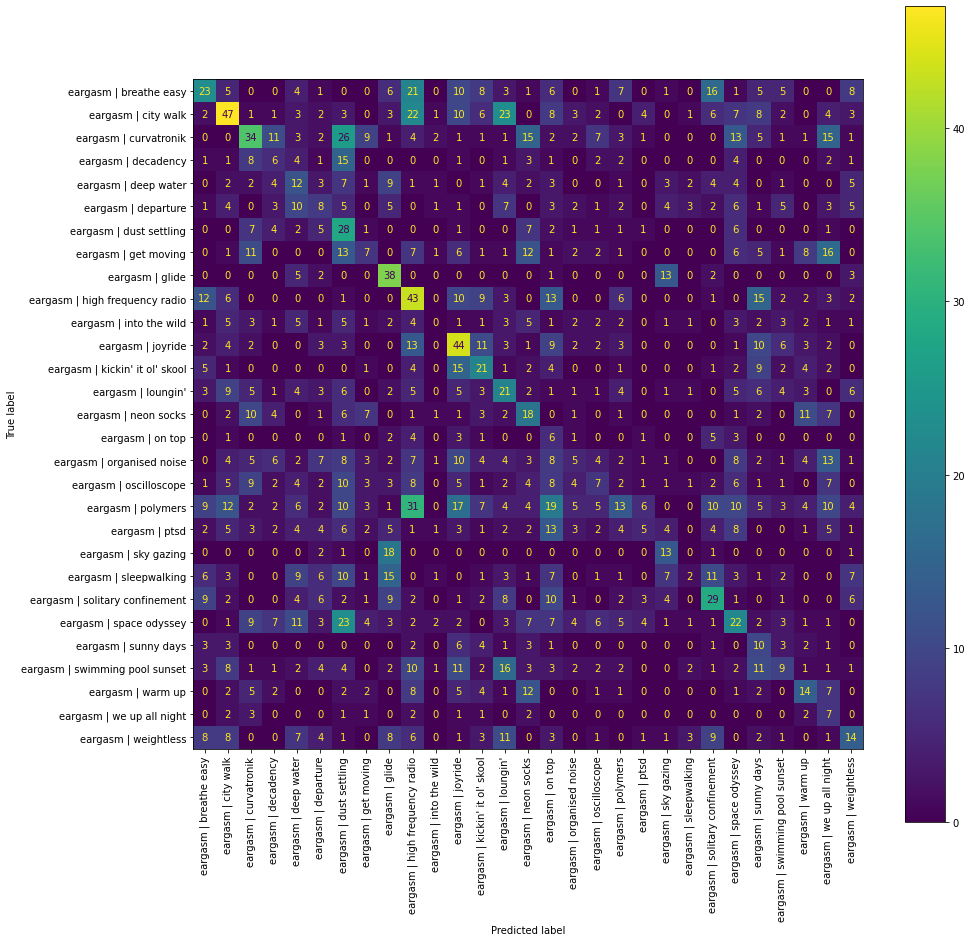

In [69]:
clf = logreg
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(clf, X_train, y_train, ax=ax)
plt.xticks(rotation=90)

## Probability check

In [72]:
def probabilities(number):
  df = pd.DataFrame({'class': clf.classes_, 'probability': clf.predict_proba(X_test)[number]})
  df = df.sort_values(by='probability', ascending=False).head(n=3)

  index_number = X_test.index[number]
  prediction = clf.predict(X_test)[number], final_df.loc[index_number]['track_url']

  id = final_df.loc[index_number]['track_id']
  truth = final_df.loc[final_df['track_id'] == id]['track_playlist']
  return print('Prediction: \n {}\n\n Probabilities: \n {}\n\n Truth:\n{}'.format(prediction, df, truth))

In [80]:
clf = lda
random_number = np.random.randint(0, X_test.shape[0])
probabilities(random_number)

Prediction: 
 ("eargasm | kickin' it ol' skool", 'https://open.spotify.com/track/3WwGTjkbZTQqyirs5L6fGo')

 Probabilities: 
                              class  probability
12  eargasm | kickin' it ol' skool     0.237262
11               eargasm | joyride     0.226241
9   eargasm | high frequency radio     0.148348

 Truth:
2252    eargasm | joyride
Name: track_playlist, dtype: object


In [30]:
dfghdfgjdfj

NameError: ignored

### Random Forest Classifier

`RandomForestClassifier()` had the best `mean_score` of all estimators but looks like it's overfitting the data. It also ran significantly longer than most of the others but let's evalue it further. 

https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6

In [ ]:
pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier())
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

In [ ]:
pipe = make_pipeline(StandardScaler(), SVC())
cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()

In [ ]:
start = timeit.default_timer()

parameters = {
              'n_estimators': [10, 50, 100],
              'criterion': ['gini', 'entropy'],
              'max_depth': [3, 4, 5, 6],
              'max_features': [2, 3, 4]
             }

evaluation_results = model_evaluation(RandomForestClassifier(n_jobs=-1), parameters)

stop = timeit.default_timer()
print('Runtime: {} seconds.'.format(stop-start))

In [ ]:
evaluation_results

In [ ]:
rfc = evaluation_results['b_estimator']

In [ ]:
asdfasdgasdga asdf

### Decision Tree Classifier

`DecisionTreeClassifier()` received `mean_score` similar to `RandomForestClassifier()` and overfits similarily. However, the algorithm seems to be a lot faster, so let's give it a try.

https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

In [ ]:
from sklearn import svm

clf = make_pipeline(StandardScaler(), svm.SVC(gamma='auto', probability=True))
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

## Multilabel classification
https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value/45088911

In [ ]:
# columns = final_df.columns.to_list()
# columns.remove('track_playlist')

columns = [
           'track_id',
           'track_url',
           'acousticness',
           'danceability',
           'instrumentalness',
           'valence',
           'tempo',
           'track_duration',
           'track_popularity',
           'track_playlist'
          ]

# df_nodup = final_df.copy()
df = final_df.copy()[columns]

df = df.groupby(['track_id', 'track_url', 'acousticness', 'danceability', 'instrumentalness', 'valence', 'tempo', 'track_duration', 'track_popularity']).agg(list).reset_index()
df.head()



In [ ]:
X = df.drop(columns=['track_id', 'track_playlist', 'track_url'])
y = df['track_playlist']

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

y = pd.DataFrame(mlb.fit_transform(y), columns=mlb.classes_)

# y_converted = mlb.fit_transform(y)
# y_converted
y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=0)

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier()
# clf.fit(X_train, y_train)
# clf.score(X_test, y_test)
# # cross_val_score(clf, X_test, y_test, cv=10).mean()


In [ ]:
y_pred = pd.Series(mlb.inverse_transform(clf.predict(X_test)))
y_pred[530]


In [ ]:
X_test.iloc[520]

In [ ]:
index_number = X_test.index[520]
index_number

In [ ]:
df.loc[index_number]['track_url']

In [ ]:
def check_multilabel(number):
  # index_number = X_test.index[590]
  # pl_names = y_test.columns
  # mask = clf.predict(X_test)[590].astype(bool)
  # id = df.loc[index_number]['track_id']
  # preds = pl_names[mask]
  # url = final_df.loc[final_df['track_id'] == '7pHujzt4Naoo4czUgxBQyr']['track_url']
  return print(preds, url)

In [ ]:
check_multilabel(590)

## Multi output

In [ ]:
X = df_encoded[['acousticness', 'danceability', 'instrumentalness', 'valence', 'tempo', 'track_duration', 'track_popularity']]
y = df_encoded['track_playlist']

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
# mlb.classes_

In [ ]:
# from sklearn.preprocessing import MultiLabelBinarizer
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(y)

# Y_train = mlb.fit_transform(y_train)
# Y_test = mlb.fit_transform(y_test)
# Y_train[0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
clf.predict_proba(X_test)

## Shit

In [ ]:
# X = df_encoded.drop('track_playlist', axis='columns')
# y = df_encoded['track_playlist']

In [ ]:
# ordinal_categories = [
#                       'track_duration',
#                       'track_popularity',
#                       'acousticness',
#                       'danceability',
#                       'energy',
#                       'instrumentalness',
#                       'liveness',
#                       'speechiness',
#                       'valence',
#                       'tempo'
#                      ]

# nominal_categories = [
#                       'track_genre',
#                       'key',
#                       'mode',
#                       'time_signature'
#                      ]
# column_transformer = make_column_transformer(
#     (OneHotEncoder(sparse=False, handle_unknown = 'ignore'), nominal_categories),
#     remainder='passthrough'
#     )
# column_transformer.fit_transform(X)

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier()

In [ ]:
# pipe = make_pipeline(column_transformer, knn)

In [ ]:
# cross_val_score(knn, X, y, cv=5, scoring='accuracy').mean()

In [ ]:
# ohe = OneHotEncoder(sparse=False)
# ohe.fit_transform(X_encoded[['track_genre']]).shape
# ohe.categories_
# # pe = OrdinalEncoder()



In [ ]:
# encoder = ce.BinaryEncoder(cols=['track_artist', 'track_genre'])
# X_encoded = encoder.fit_transform(X_encoded)

# X_encoded.head()

In [ ]:
# X_encoded['track_duration'] = X_encoded['track_duration'].apply(lambda x: int(x/1000))

# X_encoded['tempo'].fillna(X_encoded['tempo'].mean(), inplace=True)
# X_encoded['tempo'] = X_encoded['tempo'].apply(lambda x: int(x))
# X_encoded.head()

In [ ]:
# X_encoded['track_releasedate_year'] = X_encoded['track_releasedate'].apply(lambda x: pd.to_datetime(x).year)
# X_encoded['track_releasedate_month'] = X_encoded['track_releasedate'].apply(lambda x: pd.to_datetime(x).month)
# X_encoded.drop(columns=['track_releasedate'], inplace=True)
# X_encoded.head()

In [ ]:
# encoder = ce.OneHotEncoder(cols=['key', 'mode', 'number_of_sections', 'time_signature'])
# X_encoded = encoder.fit_transform(X_encoded)

# X_encoded.head()

In [ ]:
# features=['key', 'mode', 'tempo', 'time_signature']
# for feat in features:
#   X_encoded[feat].fillna(X_encoded[feat].mean(), inplace=True)

# References
- https://contrib.scikit-learn.org/category_encoders/
- https://www.datacamp.com/community/tutorials/categorical-data
- https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
- https://opendatascience.com/a-machine-learning-deep-dive-into-my-spotify-data/
- https://www.kaggle.com/lowkimhoe/prediction-model-on-spotify-classification